<a href="https://colab.research.google.com/github/lewirbi/ee_ipl_uv/blob/master/examples/cloudscore_different_preds-S2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Table of Contents

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/IPL-UV/ee_ipl_uv/blob/master/examples/cloudscore_different_preds-S2.ipynb)

* [Persistence method](#Persistence-method)
* [Percentile method](#Percentile-method)
* [Percentile method without threshold in reflectance](#Percentile-method-without-threshold-in-reflectance)
* [Percentile method without clustering](#Percentile-method-without-clustering)


The following code contains examples of appplying the different multitemporal cloud detection methodologies proposed in ([Mateo-Garcia et al 2018](http://dx.doi.org/10.3390/rs10071079)). Even though in the paper we only tested our method in Landsat-8, recently we adapted our code for Sentinel-2. This notebook contains an example of applying the methodology to Sentinel-2.

In [1]:
# # To be run in google colab.
!pip install git+https://github.com/IPL-UV/ee_ipl_uv#egg=ee_ipl_uv
!earthengine authenticate

  Cloning https://github.com/IPL-UV/ee_ipl_uv to /tmp/pip-install-lte72_00/ee-ipl-uv
  Running command git clone -q https://github.com/IPL-UV/ee_ipl_uv /tmp/pip-install-lte72_00/ee-ipl-uv
  Created wheel for ee-ipl-uv: filename=ee_ipl_uv-0.1-cp37-none-any.whl size=1888007 sha256=846e73ef40b0f79c0b0e4f1763924b821bcbd9817606dacb572c853c82eccc08
  Stored in directory: /tmp/pip-ephem-wheel-cache-n04h8trs/wheels/67/a9/3d/c0275de994b5906a6df7726f74bfbcbb54d3d861d40370c3a1
Successfully built ee-ipl-uv
Instructions for updating:
non-resource variables are not supported in the long term
To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googlea

In [11]:
import ee
from datetime import datetime
from IPython.display import Image, display,HTML
from ee_ipl_uv import multitemporal_cloud_masking
from ee_ipl_uv import download, image_wrapper
import os
import requests
import re
from datetime import datetime


ee.Initialize()

# Select image to remove clouds

image_index = "20200801T092031_20200801T093641_T33PVM"
image_collection_name = 'COPERNICUS/S2/'
image_wrap = image_wrapper.S2L1CImage(image_index,image_collection_name)
image_predict_clouds = image_wrap.ee_img
pol = [[14.234346286105314,10.368126958445151],
[15.085786715792814,10.368126958445151],
[15.085786715792814,10.859450890787745],
[14.234346286105314,10.859450890787745],
[14.234346286105314,10.368126958445151]]


region_of_interest = ee.Geometry.Polygon(pol)
datetime_image = datetime.utcfromtimestamp(image_predict_clouds.get("system:time_start").getInfo()/1000).strftime("%Y-%m-%d %H:%M:%S")

In [12]:
# Vis image
imageRGB = image_predict_clouds.visualize(max=.3,bands=["B4","B3","B2"])
image_file_original = download.MaybeDownloadThumb(imageRGB.clip(region_of_interest),params={"dimensions": "400x400"})

def viz_cloudscore_mask(cloudscoremask):
    cloudscoremask_vis = cloudscoremask.updateMask(cloudscoremask)
    cloudscoremask_vis = cloudscoremask_vis.visualize(max=1,min=0,palette=['1f77b4', 'ff7f0e'])
    mosaic = ee.ImageCollection([imageRGB, cloudscoremask_vis]).mosaic()
    return download.MaybeDownloadThumb(mosaic.clip(region_of_interest),params={"dimensions": "400x400"})


## Persistence method

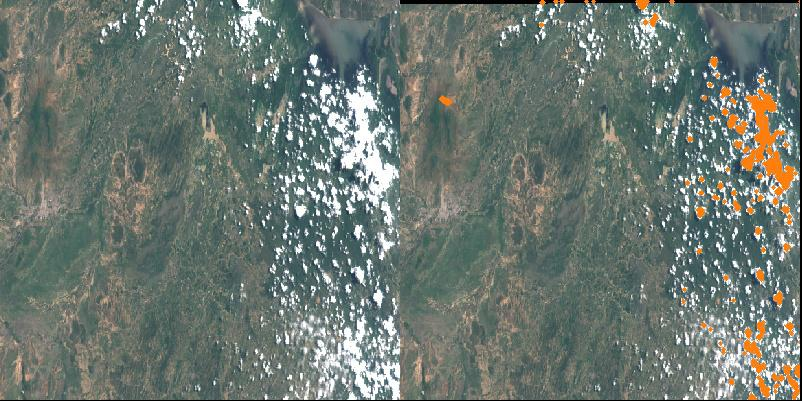

In [13]:
# Vis image + cloud mask
# Obtain cloud mask (2: cloud,1: shadow, 0: clear)
cloud_score_persistence,pred_persistence = multitemporal_cloud_masking.CloudClusterScore(image_wrap,region_of_interest,
                                                                                         method_pred="persistence")

list_images_show = [image_file_original,viz_cloudscore_mask(cloud_score_persistence)]

img_files_composite_per = download.MosaicImageList(list_images_show,
                                                   [1,len(list_images_show)])

display(Image(img_files_composite_per),
       HTML("<center>Sentinel-2 TOA image %s with clusterscore from persistence method cloud mask</center>"%datetime_image))

## Percentile method

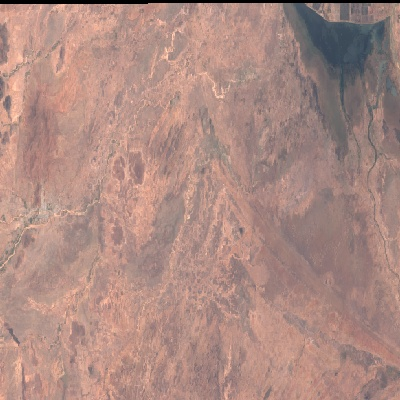

In [14]:
cloud_score_percentile,pred_percentile = multitemporal_cloud_masking.CloudClusterScore(image_wrap,region_of_interest,
                                                                                      method_pred="percentile",
                                                                                       num_images=3)
percentile_pred_file = download.MaybeDownloadThumb(pred_percentile.clip(region_of_interest),
                                                   params={"dimensions": "400x400",
                                                           "bands":"B4_forecast,B3_forecast,B2_forecast",
                                                           "max":.3})
display(Image(percentile_pred_file),
        HTML("<center>Percentile prediction</center>"))

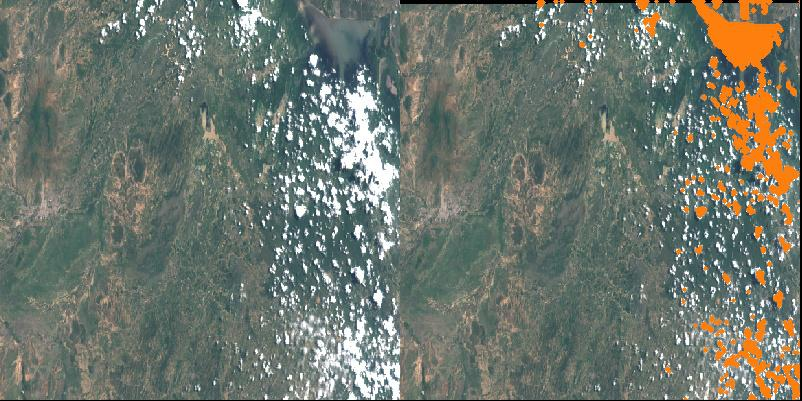

In [16]:
list_images_show = [image_file_original,viz_cloudscore_mask(cloud_score_percentile)]

img_files_composite_per = download.MosaicImageList(list_images_show,
                                                   [1,len(list_images_show)])

display(Image(img_files_composite_per),
       HTML("<center>Sentinel-2 TOA image %s with clusterscore of percentile method cloud mask</center>"%datetime_image))

## Percentile method without threshold in reflectance

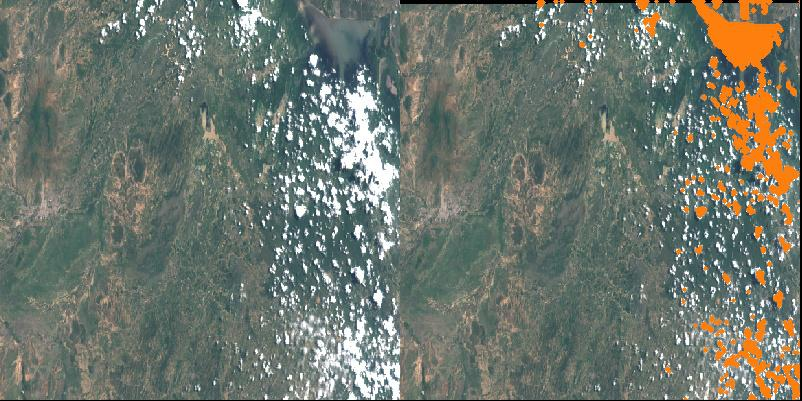

In [17]:
cloud_score_percentile,pred_percentile = multitemporal_cloud_masking.CloudClusterScore(image_wrap,region_of_interest,
                                                                                       method_pred="percentile",
                                                                                       params={"threshold_reflectance":0},
                                                                                       num_images=3)

list_images_show = [image_file_original,viz_cloudscore_mask(cloud_score_percentile)]

img_files_composite_per = download.MosaicImageList(list_images_show,
                                                   [1,len(list_images_show)])
display(Image(img_files_composite_per),
       HTML("<center>Sentinel-2 TOA image %s with clusterscore of percentile method cloud mask</center>"%datetime_image))

## Percentile method without clustering

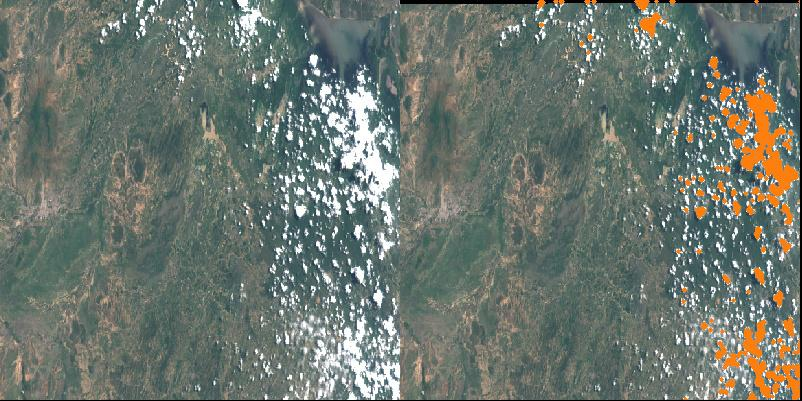

In [18]:
cloud_score_percentile,pred_percentile = multitemporal_cloud_masking.CloudClusterScore(image_wrap,region_of_interest,
                                                                                       method_pred="percentile",
                                                                                       params={"do_clustering":False},
                                                                                       num_images=3)
list_images_show = [image_file_original,viz_cloudscore_mask(cloud_score_percentile)]

img_files_composite_per = download.MosaicImageList(list_images_show,
                                                   [1,len(list_images_show)])

display(Image(img_files_composite_per),
       HTML("<center>Sentinel-2 TOA image %s with clusterscore of percentile method cloud mask</center>"%datetime_image))